## Project - Pseudo-Labeling

##### Name: JAECHAN PARK
##### Student Number : K11850713
##### Contact E-mail : k11850713@students.jku.at
##### Supervisor : Dr. Andreu Vall

In [1]:
import numpy as np
import pandas as pd
import rdkit
import torch
import pickle
from rdkit.Chem import DataStructs
from rdkit.Chem import RDConfig
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, PandasTools, Descriptors
from rdkit.Chem.Draw import IPythonConsole
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from sklearn.feature_selection import VarianceThreshold
import torch.nn as nn
from torch import optim

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
torch.cuda.is_available()

True

In [3]:
# load the provided dataset

with open('clintox_as_dict.pkl', 'rb') as f:
    data = pickle.load(f)

In [4]:
data

{'X': array([[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [0., 1.],
        [0., 1.],
        [0., 1.]]),
 'train_idx': array([   0,    1,    2, ..., 1480, 1482, 1483], dtype=int64),
 'test_idx': array([  11,   26,   27,   28,   31,   35,   36,   39,   44,   46,   60,
          70,   72,   75,   76,   88,   90,   91,   95,   97,   98,  102,
         103,  110,  116,  120,  122,  128,  130,  135,  136,  137,  143,
         146,  153,  156,  159,  170,  174,  176,  179,  180,  185,  187,
         191,  201,  209,  212,  215,  217,  219,  223,  225,  228,  232,
         237,  238,  249,  251,  261,  273,  274,  290,  291,  292,  294,
         303,  304,  306,  309,  310,  315,  317,  327,  334,  345,  346,
         34

In [5]:
data['X']

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
# Convert the format of the molecular descriptor fingerprint to pandas DataFrame

X_pd = pd.DataFrame(data['X'])

In [7]:
X_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,2284,2285,2286,2287,2288,2289,2290,2291,2292,2293
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [8]:
y_pd = pd.DataFrame(data['y'])

In [9]:
# Concatenate the descriptor fingerprint and corresponding labels ('CT_TOX') 

combined_data = pd.concat([X_pd,y_pd[0]], axis=1)

In [10]:
combined_data.columns = [*combined_data.columns[:-1], 'CT_TOX']


In [11]:
combined_data.head()

,0,1,2,3,4,5,6,7,8,9,...,2285,2286,2287,2288,2289,2290,2291,2292,2293,CT_TOX
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


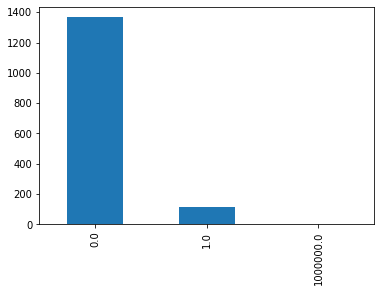

In [12]:
combined_data['CT_TOX'].value_counts().plot(kind='bar')

In [13]:
combined_data['CT_TOX'].value_counts()

0.0          1366
1.0           112
1000000.0       6
Name: CT_TOX, dtype: int64

In [14]:
# According to the bar chart, there are 6 abnormal value of labels from the dataset.
# To prevent noise from input source, the labels have to be removed.


In [15]:
combined_data_cleaned = combined_data.drop(combined_data.loc[combined_data['CT_TOX'] == 1000000.0 ].index)

In [16]:
# after removed the six unfavorable labels 

combined_data_cleaned.head()

,0,1,2,3,4,5,6,7,8,9,...,2285,2286,2287,2288,2289,2290,2291,2292,2293,CT_TOX
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


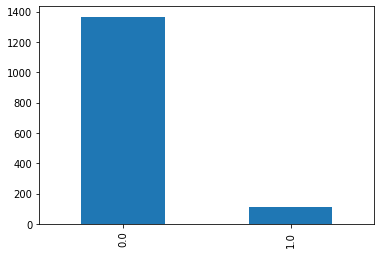

In [17]:
# make another bar plot after excluded the six labels

combined_data_cleaned['CT_TOX'].value_counts().plot(kind='bar')

In [18]:
train_index = data['train_idx']

In [19]:
# make a list of train index to make a subset from the dataset.

train_idx_list = list(train_index)

In [20]:
## Make a subset from the dataset(combined_data_cleaned) along the list of train_index

train_data = pd.DataFrame(combined_data_cleaned, train_idx_list)

In [21]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,2285,2286,2287,2288,2289,2290,2291,2292,2293,CT_TOX
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [22]:
# Split into two data sets - train set and validation set (the ratio is 0.85:0.15)

train_label = train_data.iloc[:,[2294]]
train_data_no_label = train_data.iloc[:,0:2294]
X_train, X_val, y_train, y_val = train_test_split(train_data_no_label, train_label , train_size=0.85, random_state=42)

X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,2284,2285,2286,2287,2288,2289,2290,2291,2292,2293
73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
815,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
539,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [23]:
# The remaining data samples after created the valiation data set has to be 
# separated into halves.

X_train_A, X_train_B, y_train_A, y_train_B = train_test_split(X_train, y_train, train_size=0.50, random_state=42)

X_train_A.head()


,0,1,2,3,4,5,6,7,8,9,...,2284,2285,2286,2287,2288,2289,2290,2291,2292,2293
1379,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
339,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
X_train_combined= pd.concat([X_train_A,y_train_A], axis=1)

In [25]:
X_train_combined.head()

,0,1,2,3,4,5,6,7,8,9,...,2285,2286,2287,2288,2289,2290,2291,2292,2293,CT_TOX
1379,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
339,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
## Create 4 layers of neural network (1 input layer, 2 hidden layers, 1 output layer)

In [27]:
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        
        self.layer_1 = nn.Linear(2294,1100)
        self.layer_2 = nn.Linear(1100,520)
        self.layer_3 = nn.Linear(520,240)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.output = nn.Linear(240, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward (self, X,**kwargs):
        X = self.layer_1(X)
        X = self.relu(X)
        X = self.layer_2(X)
        X = self.relu(X)
        X = self.dropout(X)
        X = self.layer_3(X)
        X = self.relu(X)
        X = self.dropout(X)
        X = self.output(X)
        X = self.sigmoid(X)
        
        return X
    
    def predict(self,x):
        
        pred_list = []
        #Pick the class with maximum weight 
        x_list = x.tolist()
        
        for i in x_list:
            if i[0]<0.5:
                pred_list.append(0)
            else:
                pred_list.append(1)
    
        return torch.tensor(pred_list)

In [28]:
# This function is to convert a dataset into the torch.tensor format for passing
# through the neural network.

def torch_tensor(data):
    
    temp = np.array(data)
    temp = temp.astype(np.float32)
    temp_tensor = torch.from_numpy(temp)
    
    return temp_tensor

In [29]:
# convert the X_train_A dataset into the torch.tensor format to apply the network.

train_A_tensor = torch_tensor(X_train_A)
train_A_label_tensor = torch_tensor(y_train_A)

In [30]:
# convert the X_train_B dataset into the torch.tensor format to apply the network.
train_B_tensor = torch_tensor(X_train_B)
train_B_label_tensor = torch_tensor(y_train_B)

In [31]:
# convert the validation dataset into the torch.tensor format to apply the network.

val_data_tensor = torch_tensor(X_val)
val_label_tensor = torch_tensor(y_val)

In [32]:
## Please note that this is just provisional work for this project.
## Hence, there is a lot of room to improve the learning model and be modified. 
## the learning rate and other parameter settings will be optimized in later

In [33]:
model = FNN()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(),lr=0.1, momentum=0.20)


In [34]:
output = model.forward(train_A_tensor)


In [35]:
loss = criterion(output,train_A_label_tensor)

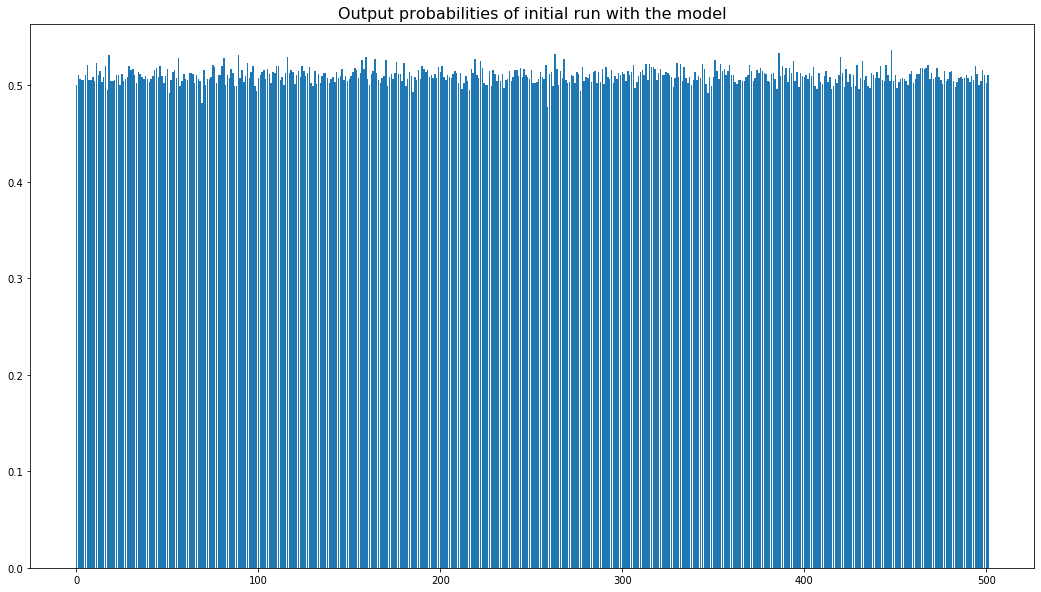

In [36]:
# The following plot represents the probability after initialized the network.
# The result returns that all of the input data samples have their probability at around 0.5

output_prob = model.forward(train_A_tensor).detach().numpy().flatten()
plt.figure(figsize=(18,10))
plt.title("Output probabilities of initial run with the model",fontsize=16)
plt.bar([i for i in range(len(train_A_tensor))],height=output_prob)
plt.show()

In [37]:
# run 300 epoch to train the network with validation set

epochs = 300
loss_list = []
val_losses =[]  

for i,e in enumerate(range(epochs)):
    optimizer.zero_grad()
    output = model.forward(train_A_tensor)
    loss = criterion(output,train_A_label_tensor)
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    
    with torch.no_grad():
        
        y_pred = model.forward(val_data_tensor)
        val_loss = criterion(val_label_tensor, y_pred)
        val_losses.append(val_loss.item())

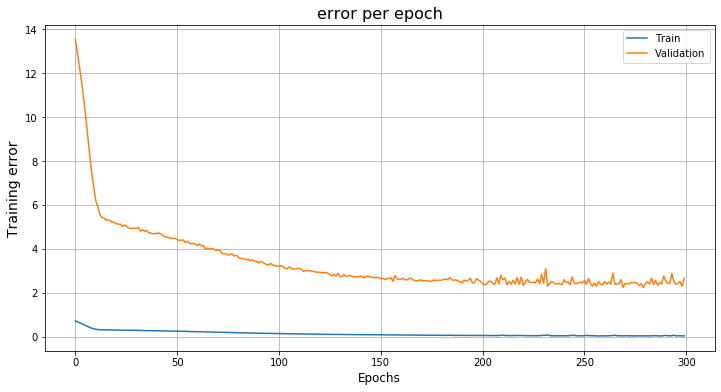

In [38]:
plt.figure(figsize=(12,6))
plt.title("error per epoch",fontsize=16)
plt.plot([e for e in range(epochs)],loss_list)
plt.plot([e for e in range(epochs)],val_losses)
plt.grid(True)
plt.xlabel("Epochs",fontsize=12)
plt.ylabel("Training error",fontsize=14)
plt.legend(['Train', 'Validation'])
plt.show()

In [39]:
##  Pseudo_Labeling ###

# In this section, the dataset, X_train_B, will be assiend predicted labels by the trained network.

In [40]:
y_pred_B = model.forward(train_B_tensor)

In [41]:
pseudo_label_train_B = model.predict(y_pred_B)

In [43]:
pseudo_label_train_B

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [44]:
## Supervised-Learning with the combined of X_train_A (with "labels") and X_train_B (with "Pseudo-Labels")

In [45]:
X_train_A_and_labels = pd.concat([X_train_A,y_train_A],axis=1)

In [46]:
X_train_A_and_labels.head()

,0,1,2,3,4,5,6,7,8,9,...,2285,2286,2287,2288,2289,2290,2291,2292,2293,CT_TOX
1379,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
339,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
X_train_B_np = np.asarray(train_B_tensor)
X_train_B_pd = pd.DataFrame(X_train_B_np)
X_train_B_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,2284,2285,2286,2287,2288,2289,2290,2291,2292,2293
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [48]:
pseudo_label_train_B_np = np.asarray(pseudo_label_train_B)
pseudo_label_B = pd.DataFrame(pseudo_label_train_B_np)
pseudo_label_B = pd.DataFrame(pseudo_label_train_B_np)
X_train_B_and_labels = pd.concat([X_train_B_pd,pseudo_label_B], axis=1)

In [49]:
X_train_B_and_labels.head()

,0,1,2,3,4,5,6,7,8,9,...,2285,2286,2287,2288,2289,2290,2291,2292,2293,0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


In [50]:
# rename the last column to "CT_TOX"

X_train_B_and_labels.columns = [*X_train_B_and_labels.columns[:-1], 'CT_TOX']


In [51]:
# concate the two prepared datasets for supervised learning 

train_AB = pd.concat([X_train_A_and_labels,X_train_B_and_labels])

In [52]:
# shuffle the rows randomly

from sklearn.utils import shuffle
train_AB_shuffled = shuffle(train_AB)

In [53]:
train_AB_shuffled

,0,1,2,3,4,5,6,7,8,9,...,2285,2286,2287,2288,2289,2290,2291,2292,2293,CT_TOX
1113,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
305,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
293,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
24,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
426,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1448,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [54]:
# split the training dataset and their labels

train_AB_label = train_AB_shuffled.iloc[:,[2294]]
train_AB_data = train_AB_shuffled.iloc[:,0:2294]

In [55]:
train_AB_tensor = torch_tensor(train_AB_data)
train_AB_label_tensor = torch_tensor(train_AB_label)

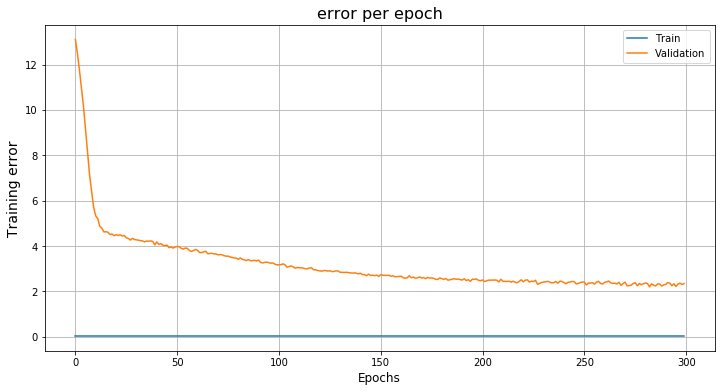

In [56]:
## conduct supervised learning with the same settings and parameters as the previous work.

model = FNN()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(),lr=0.1, momentum=0.20)


epochs = 300
loss_list_full = []
val_losses_full =[]  

for i,e in enumerate(range(epochs)):
    optimizer.zero_grad()
    output = model.forward(train_AB_tensor)
    loss_full = criterion(output,train_AB_label_tensor)
    loss_full.backward()
    optimizer.step()
    loss_list_full.append(loss.item())
    
    with torch.no_grad():
        
        y_pred = model.forward(val_data_tensor)
        val_loss_full = criterion(val_label_tensor, y_pred)
        val_losses_full.append(val_loss_full.item())

plt.figure(figsize=(12,6))
plt.title("error per epoch",fontsize=16)
plt.plot([e for e in range(epochs)],loss_list_full)
plt.plot([e for e in range(epochs)],val_losses_full)
plt.grid(True)
plt.xlabel("Epochs",fontsize=12)
plt.ylabel("Training error",fontsize=14)
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
## To be continued to run the provided test dataset!